In [46]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [47]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [48]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [49]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
# env_name = "Pendulum-v0"
env_name = "FrozenLake-v0"

# def make_env():
#     def _thunk():
#         env = gym.make(env_name)
#         return env

#     return _thunk

# envs = [make_env() for i in range(num_envs)]
# envs = SubprocVecEnv(envs)

env = gym.make(env_name)

[2018-06-14 18:59:03,305] Making new env: FrozenLake-v0


<h2>Neural Network</h2>

In [50]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [51]:
def state_fix(evir,states):
    new_state = np.zeros(evir.observation_space.n)
    new_state[states] =  1
    return new_state

In [53]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(model,vis=False):
    state = env.reset()
    state = state_fix(env,state)
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = np.argmax(dist.sample().cpu().numpy()[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        state = state_fix(env,state)
        if vis: env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [54]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [55]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages,model, optimizer,clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [56]:
# num_inputs  = envs.observation_space.shape[0]
# num_outputs = envs.action_space.shape[0]
    
def inizilize_prams():
    num_inputs = env.observation_space.n
    num_outputs = env.action_space.n

    #Hyper params:
    hidden_size      = 55#256
    lr               = 3e-4
    num_steps        = 17
    mini_batch_size  = 5
    ppo_epochs       = 4
    threshold_reward = 10

    model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    max_frames = 10000
    frame_idx  = 0
    test_rewards = []

    state = env.reset()
    state = state_fix(env,state)
    done = False
    early_stop = False

In [57]:


def running_params(gamma_tune, tau_tune):

    num_inputs = env.observation_space.n
    num_outputs = env.action_space.n

    #Hyper params:
    hidden_size      = 55#256
    lr               = 3e-4
    num_steps        = 17
    mini_batch_size  = 5
    ppo_epochs       = 4
    threshold_reward = 10

    model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    max_frames = 10000
    frame_idx  = 0
    test_rewards = []

    state = env.reset()
    state = state_fix(env,state)
    done = False
    early_stop = False
    
    
    
    
    while frame_idx < max_frames and not early_stop:

        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(num_steps):
        #while not done:
            #print("start")
            state = torch.FloatTensor(state).to(device).unsqueeze(0)
            dist, value = model(state)

            action = dist.sample()
            action_value = np.argmax(action.cpu().numpy()[0])
            next_state, reward, done, _ = env.step(action_value)

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            masks.append(1 - done)

            states.append(state)
            actions.append(action)

            state = next_state
            state = state_fix(env,state)
            frame_idx += 1

            if frame_idx % 1000 == 0:
                test_reward = np.mean([test_env(model) for _ in range(10)])
                test_rewards.append(test_reward)
                plot(frame_idx, test_rewards)
                if test_reward > threshold_reward: early_stop = True

        #print("next_state", next_state)
        next_state = state_fix(env,next_state)
        next_state = torch.FloatTensor(next_state).to(device).unsqueeze(0)
        _, next_value = model(next_state)


        returns = compute_gae(next_value, rewards, masks, values,gamma_tune, tau_tune)

        returns   = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values    = torch.cat(values).detach()
        states    = torch.cat(states)
        actions   = torch.cat(actions)
        advantage = returns - values

        ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage,model, optimizer)

        values = []
        policy = []
        for state_plt in range(0,16):
            state_plt = state_fix(env,state_plt)
            state_plt = torch.FloatTensor(state_plt).to(device).unsqueeze(0)
            dist, value = model(state_plt)
            action = np.argmax(dist.sample().cpu().numpy()[0])
            policy.append(action)
            values.append(value)
        #print("end_Values", values)
        #print("end_Policy", policy)
    return (policy,values, np.sum(test_rewards),(gamma_tune, tau_tune))

<h1>Running through parameters</h1>

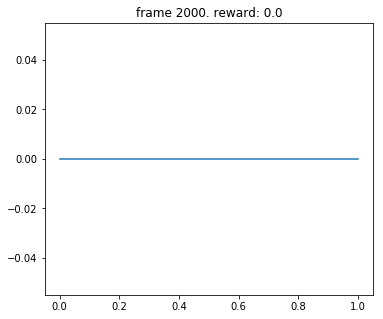

In [ ]:
gamma_tau_opt = []
top_rewards_9up = np.zeros((20,20))
top_rewards = np.zeros((10,10))
tick = -1

# for gamma_tune in range(0,9):
#     for tau_tune in range(0,9):
#         returns = running_params(gamma_tune/10, tau_tune/10)
#         #min_reward_place = min(top_rewards)
#         #if top_rewards[min_reward_place] < returns[2]:
#         top_rewards[gamma_tune][tau_tune] = returns[2]
#         gamma_tau_opt.append(returns)

eight_up = [.81,.82,.83,.84,.85,.86,.87,.88,.89,.90,.91,.92,.93,.94,.95,.96,.97,.98,.99,1]
tock = -1
for gamma_tune in range(81,101):
    tick += 1
    tock = -1
    for tau_tune in range(81,101):
        tock += 1
        returns = running_params(gamma_tune/100,tau_tune/100)
        top_rewards_9up[tick][tock] = returns[2]
        gamma_tau_opt.append(returns)

In [ ]:
#print("gamm_tao", gamma_tau_opt)
#print("top_rewards", top_rewards)
plt.imshow(top_rewards, cmap='hot', interpolation='nearest')

plt.imshow(top_rewards_9up_cp, cmap='hot', interpolation='nearest')
# plt.imshow(top_rewards_9up, cmap='hot', interpolation='nearest')
